# Import Packages and Define Utility Functions

In [129]:
%env MUJOCO_GL=egl

import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import nengo
import numpy as np
import PIL.Image

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

from dm_control import composer, mjcf, mujoco
from dm_control.utils import inverse_kinematics as ik
from IPython.display import HTML

%matplotlib widget

def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

env: MUJOCO_GL=egl


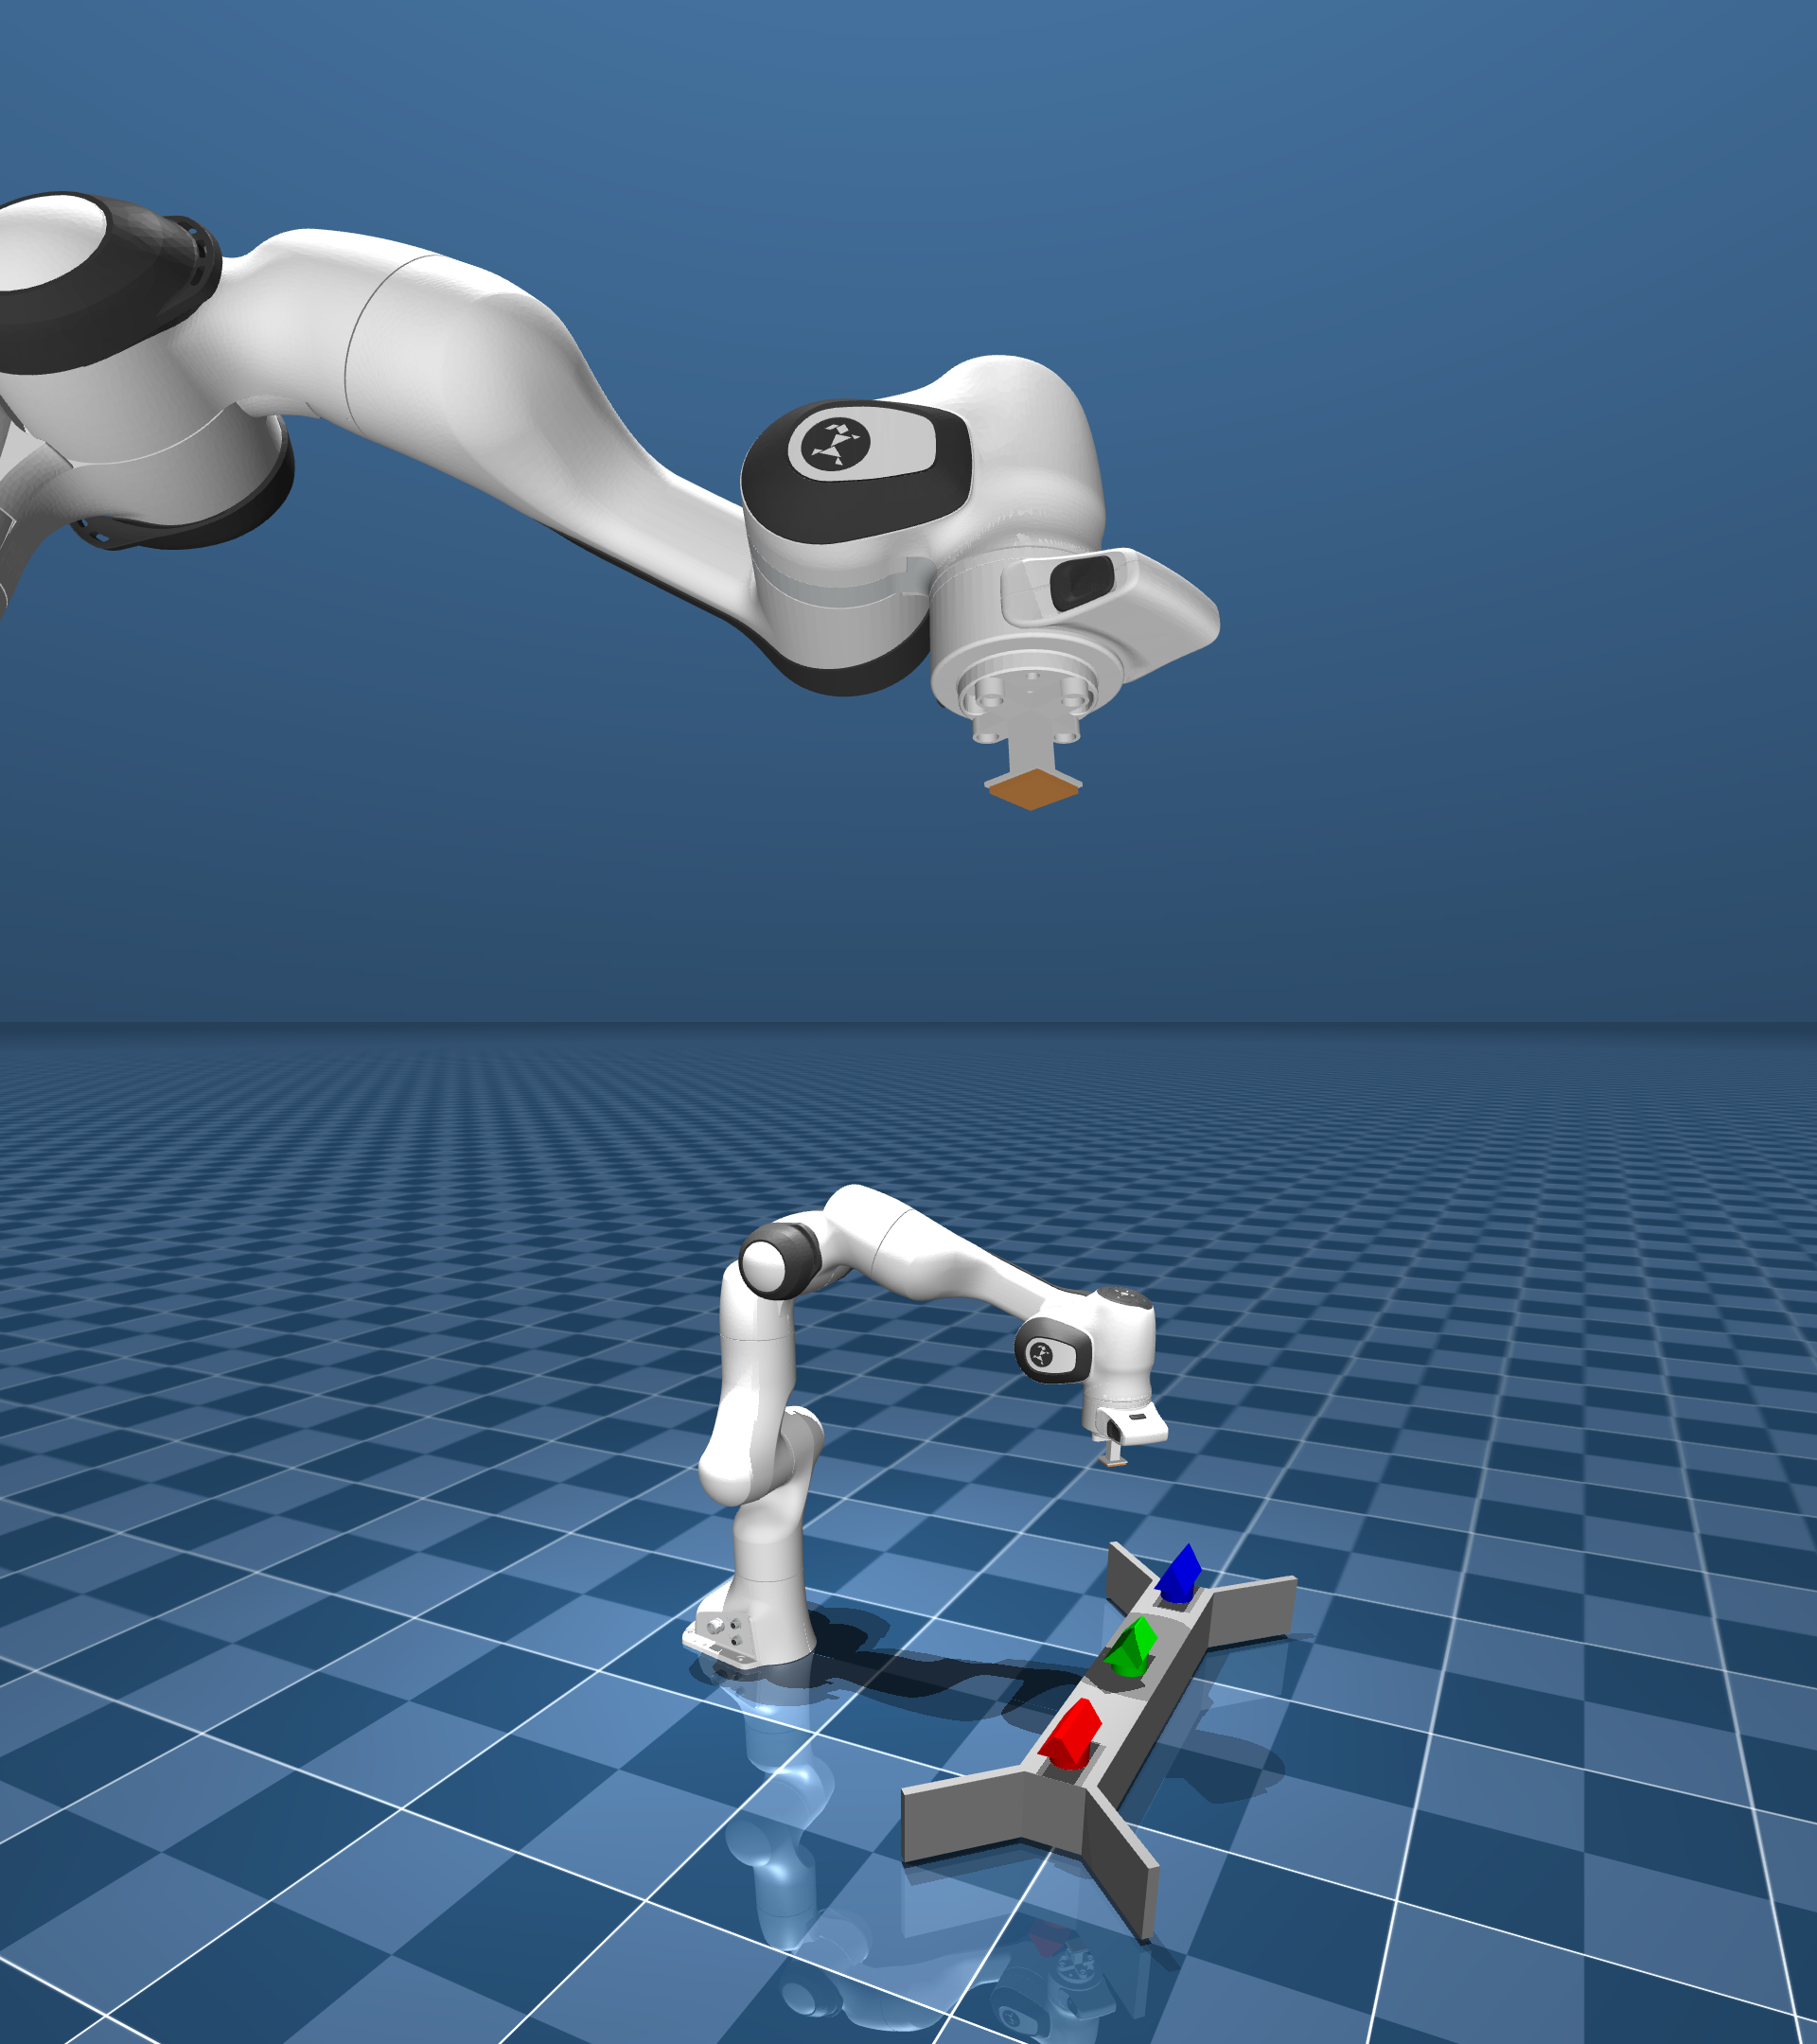

In [224]:
scene_xml = 'models/scene.xml'

physics = mujoco.Physics.from_xml_path(scene_xml)

# Set initial position
physics.reset()
physics.data.qpos[:7] = [np.pi, 0, np.pi, -2, 0, 2, 0] 
physics.step()

N = 2 # Number of cameras
random_state = np.random.RandomState(1024)
pixels = []
cameras = random_state.choice(physics.model.ncam, N, replace=False)
for camera_id in cameras:
    pixels.append(physics.render(camera_id=camera_id, width=1920, height=1080))
image = np.vstack((np.hstack(pixels[:N-1]), np.hstack(pixels[N-1:])))
PIL.Image.fromarray(image)

In [239]:
duration = 3.0 # (Seconds)
framerate = 24 # (Hz)
video = []

# IK solver parameters
_MAX_STEPS = 50
_TOL = 1e-6
site_name = 'attachment_site'
joint_names = ['joint{}'.format(i+1) for i in range(7)]

time = 0.0
omega = np.pi/2 # Rotator angular velocity

# Set initial joint positions
physics.reset()
qpos = physics.data.qpos[:7] = [np.pi, 0, np.pi, -2, 0, 2, 0]
xpos = physics.named.data.site_xpos[site_name]
physics.step()

ctrl = np.zeros(physics.data.actuator_length.shape)
ctrl[:7] = qpos

# Simulate, saving video frames
while physics.data.time < duration:
    # Inject controls and step the physics.
    t = physics.data.time
    ctrl[-3:] = omega*t
    
    ctrl[:7] = result.qpos[:7]
    physics.set_control(ctrl)
    physics.step()

    # Save video frames.
    if len(video) < physics.data.time * framerate:
        pixels = physics.render(camera_id='prospective', width=960, height=720)
        video.append(pixels.copy())

display_video(video, framerate)

# Generate Strings to Define Sensor Sites and Touch Sensors to Inject into The XML file

In [ ]:
n = 10
for i in range(n*n):
    print('{}<site name="taxel_site{}" pos="{:.6f} {:.6f} -.001" type="sphere" size=".001 .001 .001" group="4"/>'.format(' '*24, i+1, 5e-3*(i//n), 5e-3*(i%n)))
for i in range(n*n):
    print('{}<touch name="taxel{}" site="taxel_site{}"/>'.format(' '*4, i+1, i+1))